C:\Users\majak\AppData\Local\Temp\ipykernel_7412\3501037647.py:46: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Distance before disappearing:  321.52560707459827 km at 15:48
Distance when appearing:  365.4342880104348 km at 16:24


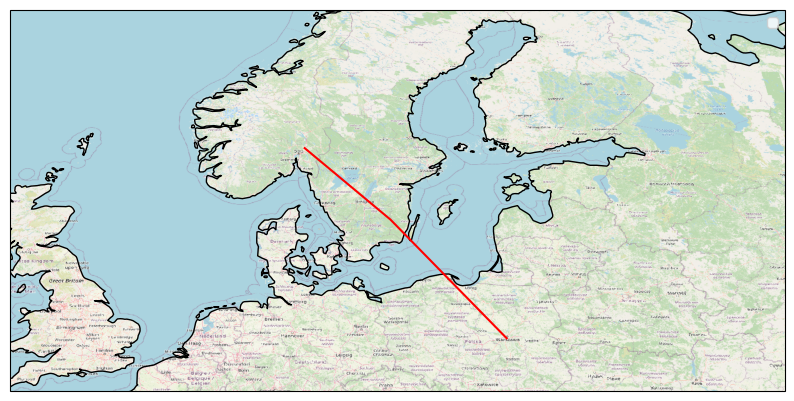

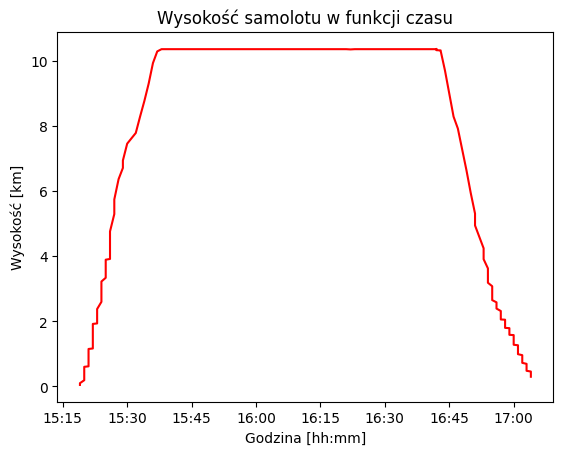

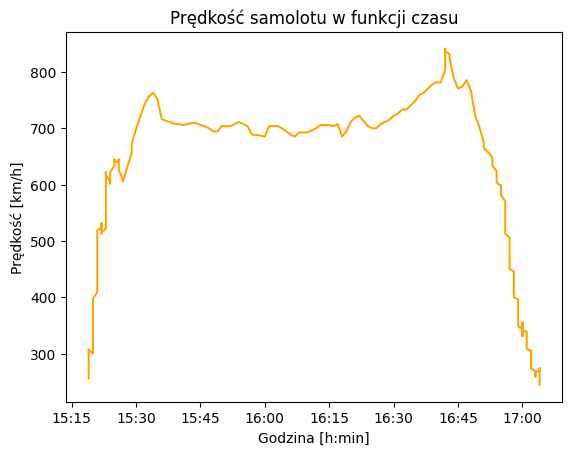

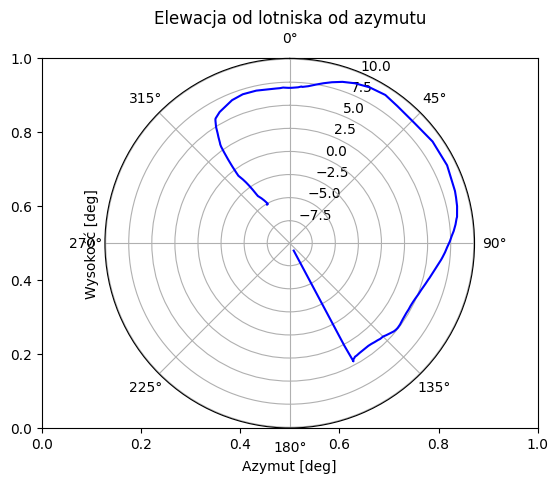

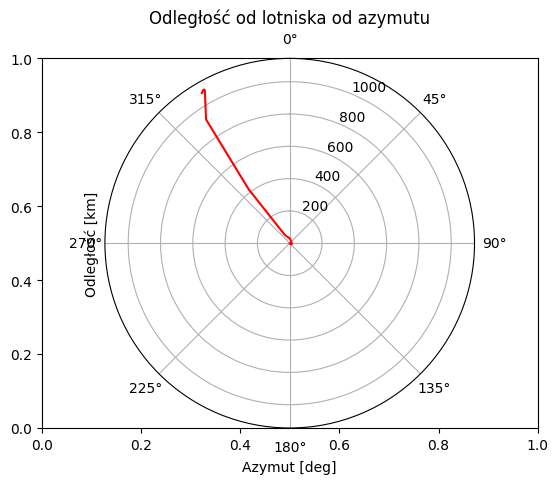

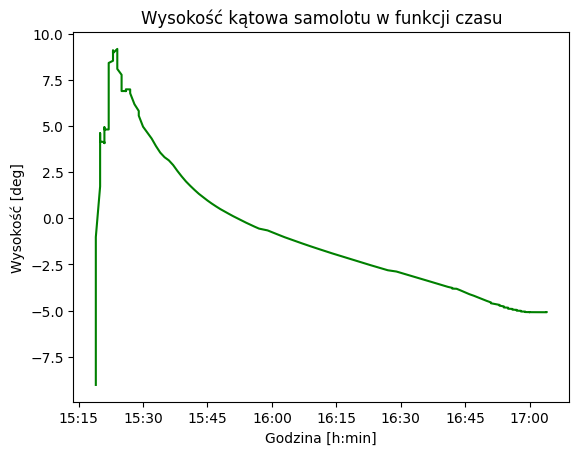

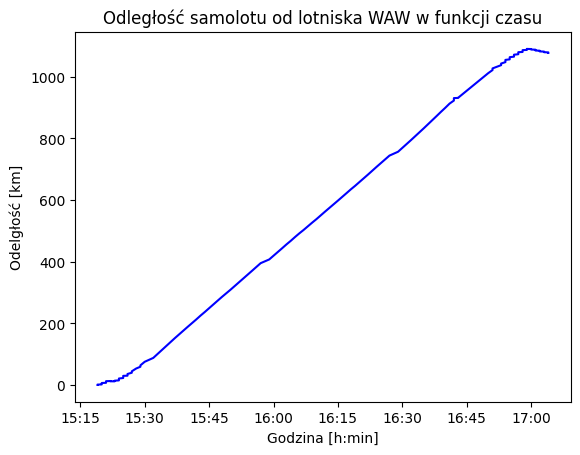

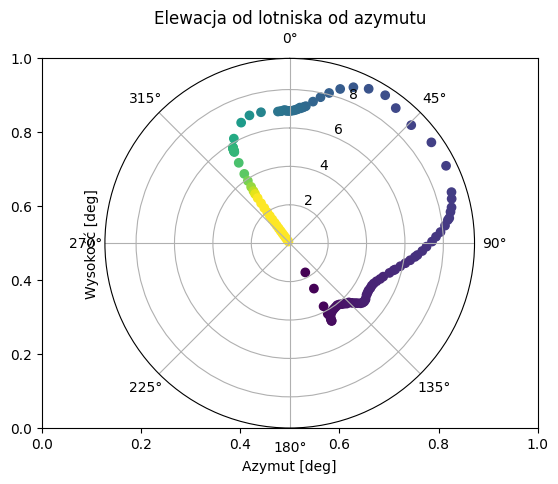

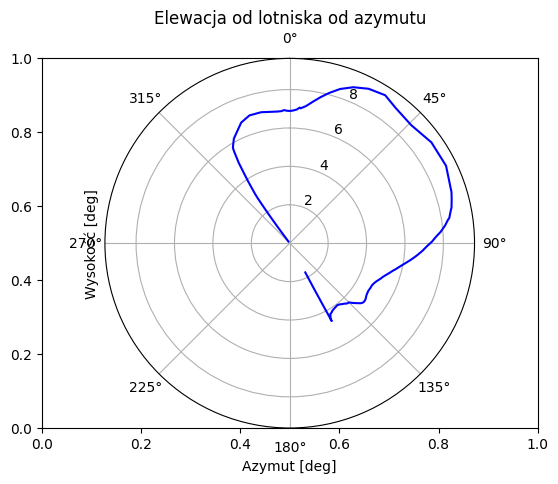

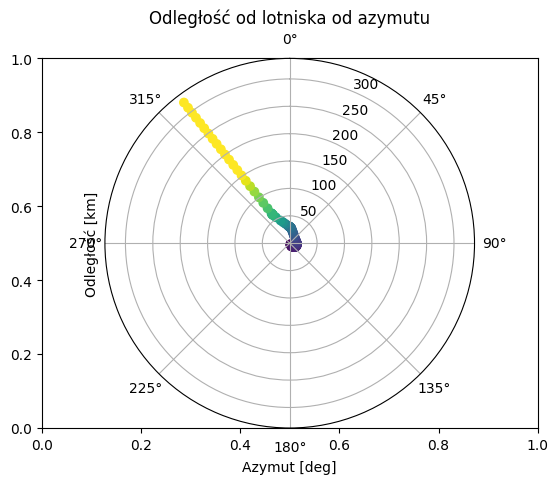

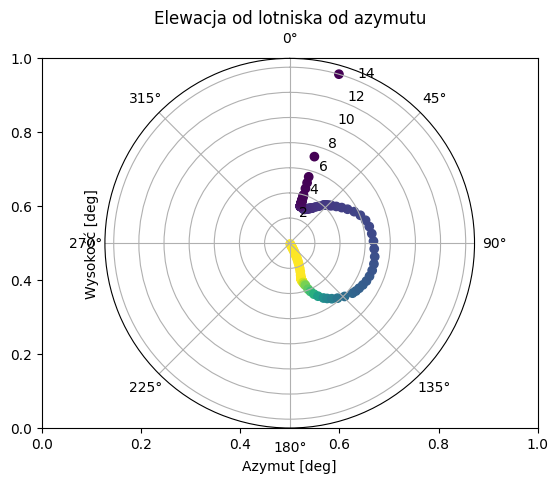

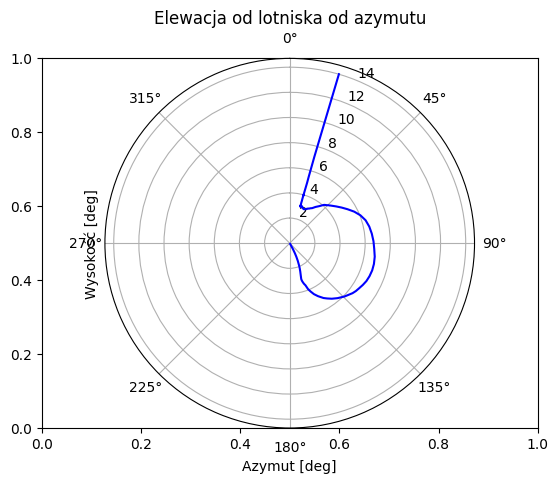

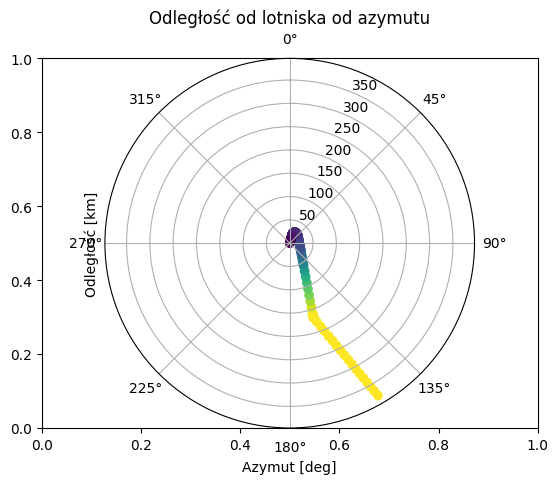

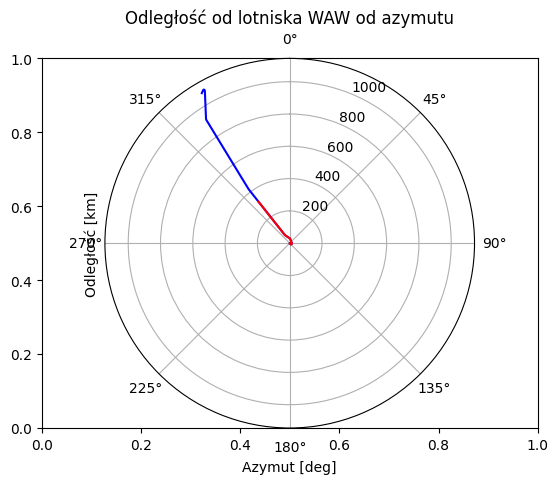

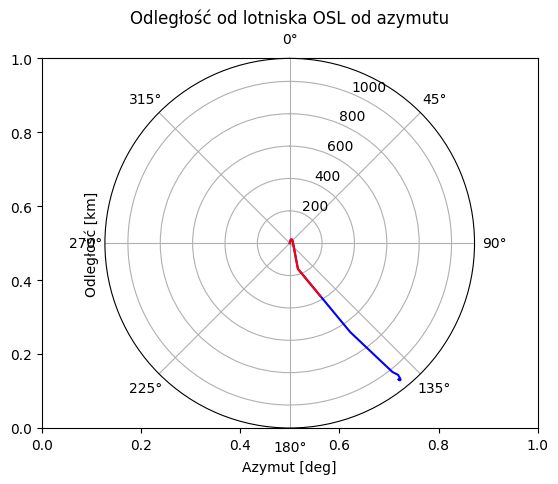

Flight time:  1:45:03
Distance:  1076.9989873141192 km
Average speed:  615.135071288407 km/h
Max speed:  840.808 km/h
Max height:  10.37082 km


In [46]:
from read_flightradar import read_flightradar
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import datetime
import os
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.dates as mdates

plik = os.path.abspath('C:\\Users\\majak\\Desktop\\sem3\\wzgw\\cw2\\lot15.csv')
dane = read_flightradar(plik)

h_norm_waw = 104
h_norm_osl = 208
undulacja = 31.4

a = 6378137.0
e2 = 0.00669438002290

# Współrzędne
wspolrzedne = dane[:, 7:10]
lot = np.where(wspolrzedne[:, -1]>0)[0]
wspolrzedne[:, -1] = wspolrzedne[:, -1] * 0.3048
wspolrzedne_lot = wspolrzedne[lot, :]
wspol_waw = wspolrzedne[lot[0]-1, :]
wspol_osl = wspolrzedne[lot[-1]+1, :]

# Czas
time_hms = dane[:, 4:7]
time_hms_lot = time_hms[lot, :]
time = time_hms[:, 0] * 60 + time_hms[:, 1] + time_hms[:, 2] / 60
time_lot = time[lot]
time_lot = time_lot - time_lot[0]

# Start i lądowanie
take_off = datetime.datetime(int(dane[lot[0], 1]), int(dane[lot[0], 2]), int(dane[lot[0], 3]), int(dane[lot[0], 4]), int(dane[lot[0], 5]), int(dane[lot[0], 6]))
landing = datetime.datetime(int(dane[lot[-1], 1]), int(dane[lot[-1], 2]), int(dane[lot[-1], 3]), int(dane[lot[-1], 4]), int(dane[lot[-1], 5]), int(dane[lot[-1], 6]))
flight_time = landing - take_off

# Oś czasu dla lotu
datetime_time_lot = [(take_off + datetime.timedelta(minutes = i)).strftime('%H:%M') for i in time_lot]
datetime_time_lot = np.array(datetime_time_lot)
datetime_time_lot = pd.to_datetime(datetime_time_lot)


# Prędkość
speed = dane[:, 10] * 1.852
speed_lot = speed[lot]

# Współrzędne lotniska WAW
phi_waw = np.deg2rad(wspol_waw[0])
lambda_waw = np.deg2rad(wspol_waw[1])
h_waw = wspol_waw[2] + h_norm_waw + undulacja

# Wspolrzedne lotniska OSL
phi_osl = np.deg2rad(wspol_osl[0])
lambda_osl = np.deg2rad(wspol_osl[1])
h_osl = wspol_osl[2] + h_norm_osl

# Funkcja przeliczająca współrzędne geograficzne na współrzędne ortogonalne
def orto(p, l, h):
    N = a / (np.sqrt(1 - e2 * np.sin(l) * np.sin(l)))
    X = (N + h) * np.cos(p) * np.cos(l)
    Y = (N + h) * np.cos(p) * np.sin(l)
    Z = (N * (1 - e2) + h) * np.sin(p)
    return([X, Y, Z])

# Funkcja obliczająca macierz obrotu
def macierz_obrotu(p, l):
    macierz = np.array([[-np.sin(p) * np.cos(l), -np.sin(l), np.cos(p) * np.cos(l)],
                        [-np.sin(p) * np.sin(l), np.cos(l), np.cos(p) * np.sin(l)],
                        [np.cos(p), 0, np.sin(p)]])
    return macierz

xyz_waw = orto(phi_waw, lambda_waw, h_waw)
R_waw = macierz_obrotu(phi_waw, lambda_waw)

xyz_osl = orto(phi_osl, lambda_osl, h_osl)
R_osl = macierz_obrotu(phi_osl, lambda_osl)

# Azymut
azimuths = []
azimuths_o = []
azimuths_waw = []
azimuths_osl = []
# Odleglosc od lotniska
distance = []
distance_o = []
distance_waw = []
distance_osl = []
# Wysokosc
height = []
height_waw = []
height_osl = []
# Czas
time_waw = []
time_osl = []

# Warszawa 
for flh in wspolrzedne_lot:
    xyz_samolotu = orto(np.deg2rad(flh[0]), np.deg2rad(flh[1]), flh[2])
    wektor_samolot_lotnisko = np.array([xyz_samolotu[0] - xyz_waw[0], xyz_samolotu[1] - xyz_waw[1], xyz_samolotu[2] - xyz_waw[2]])
    neu = R_waw.T@wektor_samolot_lotnisko
    h = np.arcsin(np.clip(neu[2] / np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2), -1, 1))
    h = np.degrees(h)
    height.append(h)

    az = np.arctan2(neu[1], neu[0])
    azimuths.append(az)

    dist = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2) / 1000
    distance.append(dist)

    if h > 0:
        height_waw.append(h)
        distance_waw.append(dist)
        azimuths_waw.append(az)
        time_waw.append(flh[2])

# Oslo
for flh in wspolrzedne_lot:
    xyz_samolotu = orto(np.deg2rad(flh[0]), np.deg2rad(flh[1]), flh[2])
    wektor_samolot_lotnisko = np.array([xyz_samolotu[0] - xyz_osl[0], xyz_samolotu[1] - xyz_osl[1], xyz_samolotu[2] - xyz_osl[2]])
    neu = R_osl.T @ wektor_samolot_lotnisko

    h = np.arcsin(np.clip(neu[2] / np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2), -1, 1))
    h = np.degrees(h)

    az = np.arctan2(neu[1], neu[0])
    az = az if az >= 0 else az + 360
    azimuths_o.append(az)
    
    dist = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2) / 1000
    distance_o.append(dist)

    if h > 0:
        height_osl.append(h)
        distance_osl.append(dist)
        azimuths_osl.append(az)
        time_osl.append(flh[2])



# Tablica współrzędnych i czasu
data_all = np.column_stack((azimuths, np.array(height), np.array(distance), np.array(time_lot)))
data_waw = np.column_stack((azimuths_waw, np.array(height_waw), np.array(distance_waw), np.array(time_waw)))
data_osl = np.column_stack((azimuths_osl, np.array(height_osl), np.array(distance_osl), np.array(time_osl)))

# Mapa lotu
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())
request = cimgt.OSM()
ax.add_image(request, 6)
ax.stock_img()
ax.coastlines()
#ax.plot(wspolrzedne_lot[:,1], wspolrzedne_lot[:,0],transform=ccrs.PlateCarree(),color='b')
ax.plot([wspol_waw[1], wspol_osl[1]], [wspol_waw[0], wspol_osl[0]], transform=ccrs.Geodetic(), color='r')
extent = [-5, 35, 50, 65]
ax.set_extent(extent)
#ax.plot(wspol_waw[1], wspol_waw[0], 'o', transform=ccrs.PlateCarree(), label = 'WAW', color='b')
#ax.plot(wspol_osl[1], wspol_osl[0], 'o', transform=ccrs.PlateCarree(), label = 'OSL', color='g')
# ax.plot(wspol_waw, wspol_osl, transform=ccrs.PlateCarree())
ax.legend()

# Mapa lokalizacji samolotu
fig = px.scatter_geo(wspolrzedne_lot,
        lat=wspolrzedne_lot[:, 0], 
        lon=wspolrzedne_lot[:, 1], 
        color = time_lot, size = 1, 
        title = 'Zarejestrowane współrzędne samolotu', 
        hover_name = time_lot, 
        projection="orthographic")
fig.update_geos(fitbounds="locations")
fig.update_layout(width = 1000, height = 1000)
fig.show()

# Linia lotu
fig = go.Figure(data=go.Scattergeo(
        lon = wspolrzedne_lot[:, 1],
        lat = wspolrzedne_lot[:, 0],
        mode = 'lines',
        line = dict(width = 2, color = 'blue')))
fig.update_geos(fitbounds="locations")
fig.update_layout(title = 'LOT4YH', width = 2000, height = 1000)

# Etykiety lotnisk
fig.add_trace(go.Scattergeo(
        lon = [wspolrzedne_lot[0, 1], wspolrzedne_lot[-1, 1]],
        lat = [wspolrzedne_lot[0, 0], wspolrzedne_lot[-1, 0]],
        mode = 'markers + text',
        marker = dict(size = 10, color = 'navy'),
        text = ['WAW'],
        textposition="top center"))
fig.add_trace(go.Scattergeo(
        lon = [wspolrzedne_lot[-1, 1], wspolrzedne_lot[-1, 1]],
        lat = [wspolrzedne_lot[-1, 0], wspolrzedne_lot[-1, 0]],
        mode = 'markers + text',
        marker = dict(size = 10, color = 'navy'),
        text = ['OSL'],
        textposition="top center"))
fig.show()


# Wysokośc od czasu
fig, ax_high_hour = plt.subplots()
ax_high_hour.plot(datetime_time_lot, wspolrzedne_lot[:, 2] / 1000, color = 'red')
ax_high_hour.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_high_hour.set_xlabel('Godzina [hh:mm]')
ax_high_hour.set_ylabel('Wysokość [km]')
ax_high_hour.set_title('Wysokość samolotu w funkcji czasu')

# Prędkość lotu od czasu
fig, ax_speed = plt.subplots()
ax_speed.plot(datetime_time_lot, speed_lot, color = 'orange')
ax_speed.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_speed.set_xlabel('Godzina [h:min]')
ax_speed.set_ylabel('Prędkość [km/h]')
ax_speed.set_title('Prędkość samolotu w funkcji czasu')

#Skyplot z elewacją w postaci linii geodezyjnej 
fig, ax = plt.subplots()
ax = plt.axes(projection = 'polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xlabel('Azymut [deg]')
ax.set_ylabel('Wysokość [deg]')
ax.plot(azimuths, height, color = 'blue')
ax.set_title('Elewacja od lotniska od azymutu')

#Skyplot z odległością w postaci linii geodezyjnej
fig, ax = plt.subplots()
ax = plt.axes(projection = 'polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True)
#ax.plot(azimuths, distance, color = 'blue')
ax.plot(azimuths, distance, color = 'red')
ax.set_xlabel('Azymut [deg]')
ax.set_ylabel('Odległość [km]')
ax.set_title('Odległość od lotniska od azymutu')

# Elewacja od godziny
fig, ax_speed = plt.subplots()
ax_speed.plot(datetime_time_lot, height, color = 'green')
ax_speed.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_speed.set_xlabel('Godzina [h:min]')
ax_speed.set_ylabel('Wysokość [deg]')
ax_speed.set_title('Wysokość kątowa samolotu w funkcji czasu')

# Odległość od godziny
fig, ax_speed = plt.subplots()
ax_speed.plot(datetime_time_lot, distance, color = 'blue')
ax_speed.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_speed.set_xlabel('Godzina [h:min]')
ax_speed.set_ylabel('Odelgłość [km]')
ax_speed.set_title('Odległość samolotu od lotniska WAW w funkcji czasu')

# Wykresy Skyplot pokazujące znikanie samolotu za horyzontem z WAW i OSL
for data in (data_waw, data_osl):
    
    #Skyplot z elewacją punkty 
    fig, ax = plt.subplots()
    ax = plt.axes(projection = 'polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xlabel('Azymut [deg]')
    ax.set_ylabel('Wysokość [deg]')
    sc = ax.scatter(data[:,0], data[:,1], c = data[:,3], cmap = 'viridis')
    ax.set_title('Elewacja od lotniska od azymutu')

    #Skyplot z elewacją w postaci linii geodezyjnej 
    fig, ax = plt.subplots()
    ax = plt.axes(projection = 'polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xlabel('Azymut [deg]')
    ax.set_ylabel('Wysokość [deg]')
    ax.plot(data[:,0], data[:,1], color = 'blue')
    ax.set_title('Elewacja od lotniska od azymutu')
    
    #Skyplot z odległością punkty 
    fig, ax = plt.subplots()
    ax = plt.axes(projection = 'polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xlabel('Azymut [deg]')
    ax.set_ylabel('Odległość [km]')
    #sc = ax.scatter(azimuths, distance, color = 'blue')
    sc = ax.scatter(data[:,0], data[:,2], c = data[:,3], cmap = 'viridis')
    ax.set_title('Odległość od lotniska od azymutu')

#Skyplot z odległością w postaci linii geodezyjnej - WAW
fig, ax = plt.subplots()
ax = plt.axes(projection = 'polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True)
ax.plot(azimuths, distance, color = 'blue')
ax.plot(data_waw[:,0], data_waw[:,2], color = 'red')
ax.set_xlabel('Azymut [deg]')
ax.set_ylabel('Odległość [km]')
ax.set_title('Odległość od lotniska WAW od azymutu')

disappear_index = np.where(data_waw[:,1] > 0)[0][-1]

print('Distance before disappearing: ', data_waw[-1, 2], 'km', 'at', datetime_time_lot[disappear_index].strftime('%H:%M'))
#Skyplot z odległością w postaci linii geodezyjnej - OSL
fig, ax = plt.subplots()
ax = plt.axes(projection = 'polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True)
ax.plot(azimuths_o, distance_o, color = 'blue')
ax.plot(data_osl[:,0], data_osl[:,2], color = 'red')
ax.set_xlabel('Azymut [deg]')
ax.set_ylabel('Odległość [km]')
ax.set_title('Odległość od lotniska OSL od azymutu')

appear_index = len(data_all) - len(data_osl) + np.where(data_osl[:,1] > 0)[0][0]

print('Distance when appearing: ', data_osl[1, 2], 'km', 'at', datetime_time_lot[appear_index].strftime('%H:%M'))

plt.show()

print('Flight time: ', flight_time)
print('Distance: ', distance[-1], 'km')
print('Average speed: ', distance[-1] / (flight_time.total_seconds() / 3600), 'km/h')
print('Max speed: ', np.max(speed_lot), 'km/h')
print('Max height: ', np.max(wspolrzedne_lot[:, 2]) / 1000, 'km')